In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

import sys
sys.path.append('..')

import modules.stats as st
import modules.plotting as pl
import modules.pandas_funcs as pf

In [2]:
results_dir = os.path.join('..', 'data', 'results')
match_dir = os.path.join('..', 'data', 'matching')


df_k_raw = pd.read_csv(os.path.join(results_dir, 'kinect_gait_metrics.csv'),
                       index_col=0)

df_z_raw = pd.read_csv(os.path.join(results_dir, 'zeno_gait_metrics.csv'),
                       index_col=0)

df_match = pd.read_csv(os.path.join(match_dir, 'match_kinect_zeno.csv'))

# Drop rows where file has no match
df_match = df_match.dropna(axis=0)


df_match_zeno = pd.merge(df_match, df_z_raw, left_on='Zeno', right_index=True)

df_total = pd.merge(df_match_zeno, df_k_raw, left_on='Kinect',
                    right_index=True, suffixes=('_z', '_k'))


# Take columns from total DataFrame to get Kinect and Zeno data
df_k = df_total.filter(like='_k')
df_z = df_total.filter(like='_z')

# Remove suffixes from column names
df_k = df_k.rename(columns=lambda x: str(x)[:-2])
df_z = df_z.rename(columns=lambda x: str(x)[:-2])

# Group by gait metric without suffix
df_k_grouped = df_k.groupby(lambda x: x[:-2], axis=1).mean()
df_z_grouped = df_z.groupby(lambda x: x[:-2], axis=1).mean()

## Visual Results

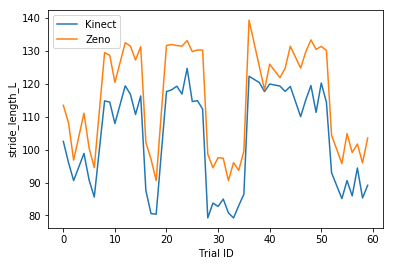

In [3]:
%matplotlib inline

metric = 'stride_length_L'

plt.plot(df_k[metric])
plt.plot(df_z[metric])

plt.xlabel('Trial ID')
plt.ylabel(metric)

plt.legend(['Kinect', 'Zeno'])
plt.show()

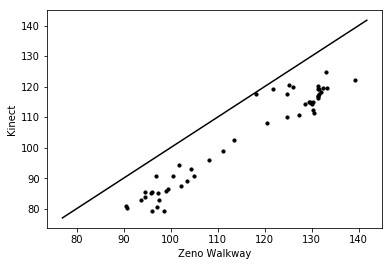

In [4]:
x_label, y_label = 'Zeno Walkway', 'Kinect'
metric = 'stride_length_L'
    
pl.compare_measurements(df_z[metric], df_k[metric], c='k', s=10)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

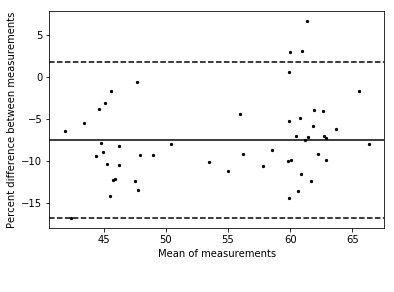

In [5]:
metric = 'step_length_L'

# Bland-Altman object
bland_obj = st.BlandAltman(df_k[metric], df_z[metric], percent=True)

pl.plot_bland_altman(bland_obj.means, bland_obj.differences, bland_obj.bias, 
                     bland_obj.limits_of_agreement, percent=True)

## Quantitative Results

In [6]:
funcs = {'Pearson': lambda a, b: pearsonr(a, b)[0],
        'Spearman': lambda a, b: spearmanr(a, b)[0],
        'Abs rel error': lambda a, b: st.relative_error(a, b, absolute=True).mean(),
        'Bias': lambda a, b: st.BlandAltman(a, b).bias, 
        'Range': lambda a, b: st.BlandAltman(a, b).range}
 
    
d = {name: pf.apply_to_columns(df_k, df_z, func) for name, func in funcs.items()}

df_results = pd.DataFrame(d).T
df_results

,step_length_L,step_length_R,stride_length_L,stride_length_R,stride_time_L,stride_time_R,stride_velocity_L,stride_velocity_R,stride_width_L,stride_width_R
Pearson,0.946325,0.974504,0.969002,0.978396,0.927243,0.906137,0.956861,0.934075,0.826994,0.916562
Spearman,0.857423,0.897891,0.890549,0.933683,0.714484,0.657156,0.849740,0.822932,0.767779,0.789209
Abs rel error,0.076792,0.123115,0.108269,0.100278,0.179189,0.160965,0.093501,0.088154,2.590749,2.913235
Bias,-0.075283,-0.131687,-0.115169,-0.106117,-0.200441,-0.175082,0.064658,0.045065,-0.460104,1.063963
Range,0.185164,0.128449,0.152055,0.133981,0.352470,0.388501,0.343986,0.373888,26.890211,16.970587


In [7]:
d = {name: pf.apply_to_columns(df_k_grouped, df_z_grouped, func) for name, func in funcs.items()}

df_grouped = pd.DataFrame(d).T
df_grouped

,step_length,stride_length,stride_time,stride_velocity,stride_width
Pearson,0.983378,0.979986,0.935400,0.954977,0.905809
Spearman,0.917357,0.911039,0.667641,0.834116,0.809186
Abs rel error,0.098250,0.104323,0.168389,0.086989,1.463903
Bias,-0.103504,-0.110548,-0.186945,0.055576,5.369364
Range,0.104752,0.125814,0.324513,0.327387,138.467346


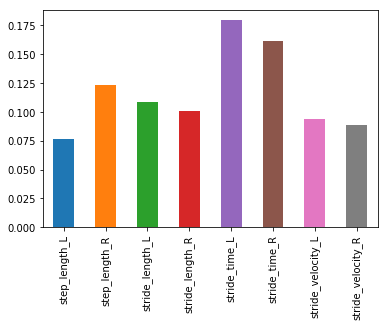

In [8]:
df_results.loc['Abs rel error'][:-2].plot.bar()

In [9]:
df_sides = df_results.groupby(lambda x: x.split('_')[-1], axis=1).mean()
df_sides

,L,R
Pearson,0.925285,0.941935
Spearman,0.815995,0.820174
Abs rel error,0.609700,0.677150
Bias,-0.157268,0.139228
Range,5.584777,3.599081


In [11]:
df_grouped.stride_length * 100

Pearson          97.998566
Spearman         91.103902
Abs rel error    10.432280
Bias            -11.054848
Range            12.581431
Name: stride_length, dtype: float64

In [12]:
df_rel_error = abs(df_k - df_z) / df_z * 100

In [13]:
max_idx = df_rel_error.stride_length_L.idxmax()